# CESM validation for FW flux paper
high vs low resolution

1. precipitation (atmosphere output: )
2. total water flux (ocean output: SFWF)

3. implied freshwater flux

In [1]:
import sys
import xesmf as xe
import numpy as np
import xarray as xr
import cartopy
import cmocean
import matplotlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.rc_file('rc_file_paper')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2
%aimport - numpy - scipy - matplotlib.pyplot

In [3]:
from maps import add_cyclic_POP
from grid import generate_lats_lons
from paths import file_ex_ocn_ctrl, file_ex_ocn_lpd, file_ex_atm_ctrl, file_ex_atm_lpd
from paths import path_results, path_prace, file_RMASK_ocn, file_RMASK_ocn_low, path_data, file_RMASK_ocn_had
from FW_budget import make_SFWF_surface_integrals
from obs_cesm_maps import bias_maps

In [4]:
RMASK_ocn = xr.open_dataarray(file_RMASK_ocn)
RMASK_low = xr.open_dataarray(file_RMASK_ocn_low)
Atl_MASK_ocn = xr.DataArray(np.in1d(RMASK_ocn, [6,8,9]).reshape(RMASK_ocn.shape),
                            dims=RMASK_ocn.dims, coords=RMASK_ocn.coords)
Atl_MASK_low = xr.DataArray(np.in1d(RMASK_low, [6,8,9]).reshape(RMASK_low.shape),
                            dims=RMASK_low.dims, coords=RMASK_low.coords)

In [5]:
dah = xr.open_dataset(file_ex_atm_ctrl, decode_times=False)
dal = xr.open_dataset(file_ex_atm_lpd , decode_times=False)
doh = xr.open_mfdataset(f'{path_prace}/ctrl/ocn_yrly_EVAP_F_PREC_F_ROFF_F_*.nc', combine='nested', concat_dim='time', decode_times=False)
dol = xr.open_mfdataset(f'{path_prace}/lpd/ocn_yrly_EVAP_F_PREC_F_ROFF_F_*.nc' , combine='nested', concat_dim='time', decode_times=False)

In [6]:
erai = xr.open_dataset('../../AMWG/obs_data/EP.ERAI_ANN_climo.nc')  # Budget Evaporation minus Precipitation
whoi = xr.open_dataset('../../AMWG/obs_data/WHOI_ANN_climo.nc')     # monthly mean evaporation rate

In [7]:
dh = xr.open_dataset(f'{path_prace}/AMWG/HIGH_CTRL_vs_OBS/diag/spinup_pd_maxcores_f05_t12_ANN_plotvars.nc', decode_times=False)
dl = xr.open_dataset(f'{path_prace}/AMWG/LOW_CTRL_vs_OBS/diag/spinup_B_2000_cam5_f09_g16_ANN_plotvars.nc', decode_times=False)

In [8]:
# regrid P-E to ECMWF grid
PE_ocn = (doh.PREC_F+doh.EVAP_F).rename({'TLAT': 'lat', 'TLONG': 'lon'}).drop(['ULONG', 'ULAT']).mean('time')
PE_low = (dol.PREC_F+dol.EVAP_F).rename({'TLAT': 'lat', 'TLONG': 'lon'}).drop(['ULONG', 'ULAT']).mean('time')

# replace NaNs in continents with values from original grid file
lats,lons = generate_lats_lons('ocn')
PE_ocn['lat'].values = lats
PE_ocn['lon'].values = lons

In [9]:
regridder_ocn = xe.Regridder(PE_ocn, erai.EP, 'nearest_s2d', reuse_weights=True, periodic=True)
regridder_low = xe.Regridder(PE_low, erai.EP, 'nearest_s2d', reuse_weights=True, periodic=True)

Reuse existing file: nearest_s2d_2400x3600_256x512_peri.nc
Reuse existing file: nearest_s2d_384x320_256x512_peri.nc


In [10]:
erai_ = xr.open_dataset(f'{path_data}/ERAI_E-P/ERAI.EP.1979-2016.t-106.nc')

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.835, 0.93, '(P$-$E)$_{Atl.}$')

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


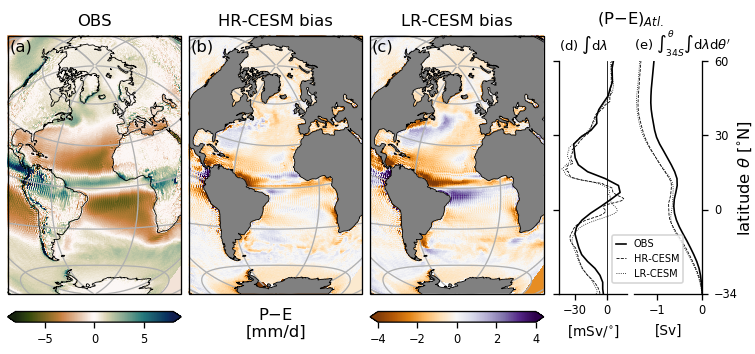

In [11]:
f = plt.figure(figsize=(6.4,3))
y, dy = 0.17, 0.73
for i in range(3):
    axt = f.add_axes([i*.24+0.01,y,.23,dy], projection=ccrs.LambertAzimuthalEqualArea(central_longitude=-30, central_latitude=20))
    axt.set_extent((-6e6, 3.5e6, -8.5e6, 1e7), crs=ccrs.LambertAzimuthalEqualArea())
    axt.set_title(['OBS', 'HR-CESM bias', 'LR-CESM bias'][i])
    
    lats, lons = erai.lat, erai.lon
    xa = -erai.EP.squeeze()*3600*24
    if i==0: 
        cax = f.add_axes([0.01,.09,.23,.03])
        maxv, cmap = 8, 'cmo.tarn'
    else:
        maxv, cmap = 4, 'PuOr'
        
    if i==1:
        xa = regridder_ocn(PE_ocn).values*3600*24 - xa.values
        minus = r'$-$'
        axt.text(0.5,-.05, f'P{minus}E\n[mm/d]', ha='center', va='top', transform=axt.transAxes)
    elif i==2:
        xa = regridder_low(PE_low).values*3600*24 - xa.values
        cax = f.add_axes([i*.24+0.01,.09,.23,.03])
        
    im = axt.pcolormesh(lons.values, lats.values, xa,
                        transform=ccrs.PlateCarree(), cmap=cmap, vmin=-maxv, vmax=maxv)
    if i in [0,2]:  
        plt.colorbar(im, cax=cax, orientation='horizontal', extend='both')
        
    gl = axt.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
    gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    if i==0:
        axt.add_feature(cartopy.feature.COASTLINE, zorder=2, edgecolor='black', linewidth=.5)
    else:
        axt.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black', facecolor='grey', linewidth=.5)
    axt.text(0.01, .94, '('+['a', 'b', 'c'][i]+')', transform=axt.transAxes)

dlate = dl.lats_ecmwf-dl.lats_ecmwf.shift(lats_ecmwf=1)
dlath = dh.lats_testcase-dh.lats_testcase.shift(lats_testcase=1)
dlatt = dl.lats_testcase-dl.lats_testcase.shift(lats_testcase=1)

ax = f.add_axes([.74,y,.09,.9*dy])
ax.set_xlabel(r'[mSv/$^{\!\circ}\!$]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([-34,0,30,60])
ax.set_ylim((-34,60))
# ax.yaxis.tick_right()
ax.set_yticklabels([])
ax.set_xticks([-30,0,30])
ax.axvline(0, c='k', lw=.5)
ax.plot((dl.oft_atl_ecmwf   -dl.oft_atl_ecmwf   .shift(lats_ecmwf   =1))/dlate*1e3, dl.lats_ecmwf   ,\
        ls='-', lw=1, c='k', label='OBS')
ax.plot((dh.oft_atl_testcase-dh.oft_atl_testcase.shift(lats_testcase=1))/dlath*1e3, dh.lats_testcase,\
        ls='--', lw=.5, c='k', label='HR-CESM')
ax.plot((dl.oft_atl_testcase-dl.oft_atl_testcase.shift(lats_testcase=1))/dlatt*1e3, dl.lats_testcase,\
        ls=':', lw=.5, c='k', label='LR-CESM')
ax.text(0,1.05,r'(d) $\int \mathrm{d} \lambda$', fontsize=8, ha='left', transform=ax.transAxes)                

ax = f.add_axes([.84,y,.09,.9*dy])
ax.set_xlabel('[Sv]')
ax.set_yticks([-34,0,30,60])
ax.set_ylim((-34,60))
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.axvline(0, c='k', lw=.5)
ax.set_xlim((-1.5,0))
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.text(1.5, .5, r'latitude $\theta$ [$\!^\circ\!$N]', va='center', rotation=90, transform=ax.transAxes)
ax.plot((dl.oft_atl_ecmwf   -dl.oft_atl_ecmwf   .isel(lats_ecmwf=19)), dl.lats_ecmwf,\
        ls='-', lw=1, c='k', label='OBS')
ax.plot((dh.oft_atl_testcase-dh.oft_atl_testcase.sel(lats_testcase=-34, method='nearest')), dh.lats_testcase,\
        ls='--', lw=.5, c='k', label='HR-CESM')
ax.plot((dl.oft_atl_testcase-dl.oft_atl_testcase.sel(lats_testcase=-34, method='nearest')), dl.lats_testcase,\
        ls=':', lw=.5, c='k', label='LR-CESM')
ax.legend(fontsize=6, handlelength=1, loc='center left', bbox_to_anchor=(-0.4,.15))

ax.text(0,1.05,r'(e) $\int_{34S}^{\theta} \int \mathrm{d} \lambda \mathrm{d} \theta ^\prime$', fontsize=8, ha='left', transform=ax.transAxes)                
f.text(.835,.93,r'(P$-$E)$_{Atl.}$', fontsize=10, ha='center')
# plt.savefig(f'{path_results}/FW-paper/Fig2', dpi=600)

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


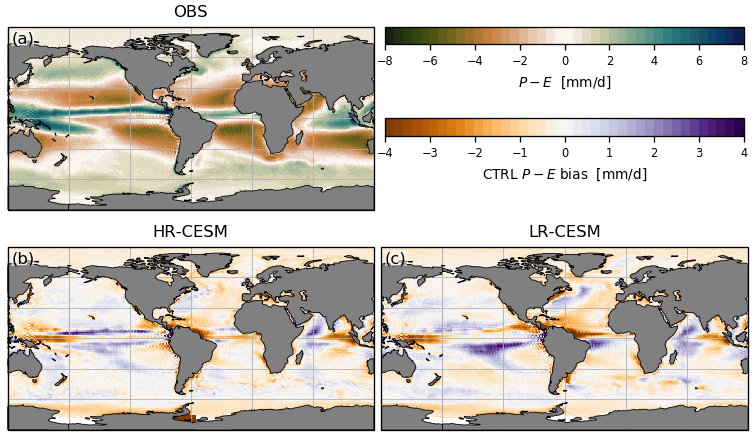

In [12]:

PmE = minus = r'$P - E$'
kw1 = dict(lat='lat', lon='lon', label=f'{PmE}  [mm/d]', cmap=plt.get_cmap('cmo.tarn', 40), vmin=-8, vmax=8)
kw2 = dict(lat='lat', lon='lon', label=f'CTRL {PmE} bias  [mm/d]', cmap=plt.get_cmap('PuOr',40), vmin=-4, vmax=4)
do = -erai.EP.squeeze()*3600*24
dh = regridder_ocn(PE_ocn).values*3600*24 - do
dl = regridder_low(PE_low).values*3600*24 - do
fn = f'{path_results}/FW-paper/SupplFig2'
# fn=None
bias_maps(do=do, dh=dh, dl=dl, kw1=kw1, kw2=kw2, fn=fn)

In [13]:
make_SFWF_surface_integrals()

----- HIGH -----

-34N to 60N,   6.41E+13 m^2

             PREC  EVAP  ROFF  TOTAL   DIFF
[mm/d]       2.62 -4.43  0.62 -1.1499  0.0360
[mm/d/100y] -0.11 -0.14  0.07 -0.2054 -0.0277
[Sv]         1.94 -3.28  0.46 -0.8532  0.0267
[Sv/100y]   -0.08 -0.10  0.05 -0.1524 -0.0205
[%/100y]     -4.2   3.1  11.4  17.9

total surface flux:   -0.85 Sv  -0.15 Sv/100yr   17.9 %/100yr





-34N to -10N,   1.58E+13 m^2

             PREC  EVAP  ROFF  TOTAL   DIFF
[mm/d]       1.47 -4.51  0.09 -2.9454  0.0000
[mm/d/100y] -0.01 -0.19  0.01 -0.1872 -0.0000
[Sv]         0.27 -0.83  0.02 -0.5392  0.0000
[Sv/100y]   -0.00 -0.03  0.00 -0.0343 -0.0000
[%/100y]     -0.8   4.2  14.9   6.4

total surface flux:   -0.54 Sv  -0.03 Sv/100yr    6.4 %/100yr





-10N to 10N,   1.29E+13 m^2

             PREC  EVAP  ROFF  TOTAL   DIFF
[mm/d]       3.53 -4.37  1.84  0.9979  0.0000
[mm/d/100y] -0.09 -0.30  0.30 -0.0957  0.0000
[Sv]         0.53 -0.65  0.28  0.1493  0.0000
[Sv/100y]   -0.01 -0.05  0.04 -0.0143  0.0000
[%